In [13]:
from sklearn.model_selection import train_test_split
import DeepMIMOv3 as DeepMIMO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from noise import *
from sklearn.preprocessing import MinMaxScaler
import torch

In [14]:
def create_dataset(scenario_name, 
                   n_bs_y, n_bs_x, n_ue_y, n_ue_x, 
                   n_paths, n_subcarriers):
    # Load the default params, set constant params
    params = DeepMIMO.default_params()
    params['dataset_folder'] = r'scenarios'
    
    # Set params
    # Which scenario
    params['scenario'] = scenario_name
    # For the antennas
    params['bs_antenna']['shape'] = np.array([n_bs_y, n_bs_x])
    params['ue_antenna']['shape'] = np.array([n_ue_y, n_ue_x])
    # For the path
    params['num_paths'] = n_paths
    params['OFDM']['subcarriers'] = n_subcarriers
    
    # Create dataset
    dataset = DeepMIMO.generate_data(params)
    
    return dataset

In [15]:
def generate_H(dataset, user):
    i = 0  # Only one base station in scenario I2
    j = user  # Choose the first user
    H = dataset[i]['user']['channel'][j]
    H = H[:, :, 0]  # Choose the first subcarrier
    return H

def generate_H_abs(dataset, user):
    H = generate_H(dataset, user)
    H_abs = np.abs(H)

    return H_abs

In [16]:
# Noise functions
def gaussian(H_true, std):
    return np.random.normal(0, std, H_true.shape)

def pink(H_true, amplitude):
    return amplitude*pink_noise(H_true)

In [17]:
# SNR
def calculate_snr(y_true, y_noise): ### write own code later
    # Calculate signal power
    signal_power = np.mean(y_true ** 2)
    # Calculate noise power
    noise_power = np.mean((y_noise - y_true) ** 2)
    # Calculate (linear) SNR
    snr = signal_power / noise_power
    # Convert to dB
    snr_db = 10 * np.log10(snr)
    return snr, snr_db

In [18]:
def generate_noisy_H(H_true, noise):
    # noise = np.random.normal(0, 10**(-5), H.shape)
    std = 10**(-4)
    if noise == gaussian:
        H_added_noise = gaussian(H_true, std)
    elif noise == 'pink':
        H_added_noise = np.zeros(H_true.shape)

    H_noise = H_true + H_added_noise

    return H_noise

In [19]:
def plot_heatmat(H):
    plt.figure(figsize=(8, 6))
    plt.imshow(H.T, cmap='viridis', aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('Channel Gain Magnitude of (RX, TX) Antenna Pairs')
    plt.xlabel('RX antenna')
    plt.ylabel('TX antenna')
    # plt.xticks(ticks=np.arange(H.shape[0]), labels=np.arange(1, H.shape[0] + 1))
    # plt.yticks(ticks=np.arange(H.shape[1]), labels=np.arange(1, H.shape[1] + 1))
    plt.show()

In [20]:
def data_generation(scenario_name, 
                    n_bs_y, n_bs_x, n_ue_y, n_ue_x,
                    n_paths, n_subcarriers,user):
    dataset = create_dataset(scenario_name, n_bs_y, n_bs_x, n_ue_y, n_ue_x, n_paths, n_subcarriers)
    #H_true = generate_H_abs(dataset, user)
    # plot_environment(dataset)
    return dataset

Change the Environment Here

In [21]:
scenario_name = 'I2_28B'
n_bs_y, n_bs_x = 32, 1
n_ue_y, n_ue_x = 32, 1
n_paths = 5
n_subcarriers = 2

Change Parameters Here

In [22]:
n_users = 20
n_samples_per_user = 10
n_datapoints = n_users * n_samples_per_user # number of (total) datapoints generated


noise = gaussian

if noise == pink:
    amplitude = 0.0001
    std = None
elif noise == gaussian:
    amplitude = None
    std = 10**(-4)

Generate & Save Datasets


Basestation 1

UE-BS Channels


Reading ray-tracing: 100%|██████████| 402/402 [00:00<00:00, 33894.39it/s]


ToA of some paths of 199 channels with an average total power of 53.50% exceed the useful OFDM symbol duration and are clipped.


Generating channels: 100%|██████████| 201/201 [00:00<00:00, 2064.05it/s]



BS-BS Channels


Generating channels: 100%|██████████| 1/1 [00:00<00:00, 1242.76it/s]


(200, 1024)
(200, 1024)


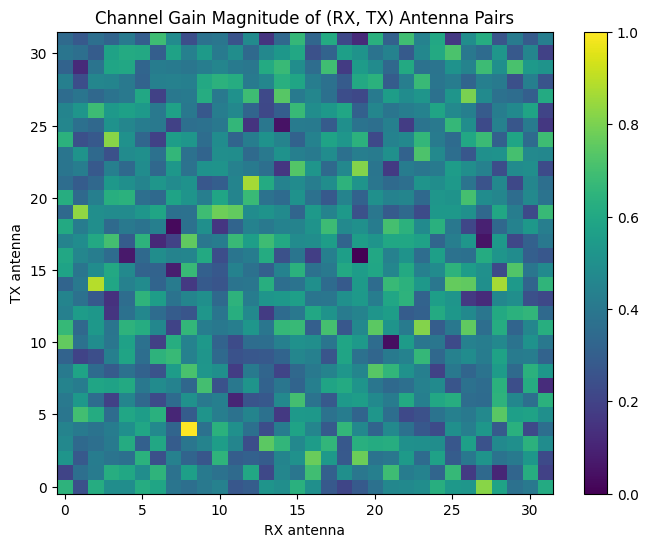

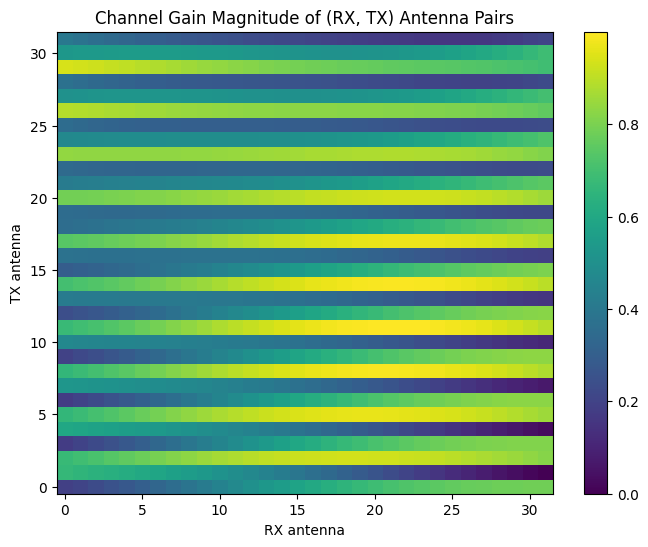

SNR: 4.31890305878085 DB: 6.35373456071338


In [23]:
scaler = MinMaxScaler()

noisy_data = np.ndarray((n_datapoints, n_bs_y * n_ue_y))
true_data = np.ndarray((n_datapoints, n_bs_y * n_ue_y))
index = 0

dataset_ = data_generation(scenario_name,
                            n_bs_y, n_bs_x, n_ue_y, n_ue_x,
                            n_paths, n_subcarriers, 0)

for user in range(1,n_users+1):
    
    H_true = generate_H_abs(dataset_, user)
    

    for i in range(n_samples_per_user):
        if noise == pink:
            H_added_noise = pink(H_true, amplitude)
        elif noise == gaussian:
            H_added_noise = gaussian(H_true, std)

        
        
        H_noise = H_true + H_added_noise
        # scaled-versions
        scaled_noisy = H_noise.flatten().reshape(-1, 1)
        scaled_noisy = scaler.fit_transform(scaled_noisy)
        scaled_true = H_true.flatten().reshape(-1, 1)
        scaled_true = scaler.fit_transform(scaled_true)



        noisy_data[index,:] = scaled_noisy.reshape(1, -1)
        true_data[index,:] = scaled_true.reshape(1, -1)
        index += 1
        

print(noisy_data.shape)
print(true_data.shape)


plot_heatmat(noisy_data[140].reshape(32,32))
plot_heatmat(true_data[140].reshape(32,32))

sum_snr = 0
sum_snr_db = 0
for i in range(noisy_data.shape[0]):
        
    snr_, snr_db = calculate_snr(true_data, noisy_data)
    sum_snr += snr_
    sum_snr_db += snr_db

snr_ = sum_snr / noisy_data.shape[0]
snr_db_ = sum_snr_db / noisy_data.shape[0]
print(f"SNR: {snr_} DB: {snr_db_}")


# create the datasets in dataframe format
true_data_df = pd.DataFrame(true_data)

noisy_data_df = pd.DataFrame(noisy_data)


# Step 1: Split 80% for training/validation and 20% for testing
X_temp, X_test, y_temp, y_test = train_test_split(
    noisy_data_df,  
    true_data_df,
    test_size=0.2,   # 20% for testing
    random_state=42  
)

# Step 2: Split the remaining 80% into 70% training and 10% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, 
    y_temp,
    test_size=0.125,  # 10% of the original total = 0.1 / 0.8 = 0.125
    random_state=42  
)



In [24]:
save = True
if save:
    folder_name = "../datasets/first_deepmimo_data"

    os.makedirs(folder_name, exist_ok=True)

    y_train.to_csv(f'{folder_name}/y_data_train.csv', index=False)
    y_val.to_csv(f'{folder_name}/y_data_val.csv', index=False)
    y_test.to_csv(f'{folder_name}/y_data_test.csv', index=False)
    X_train.to_csv(f'{folder_name}/X_data_train.csv', index=False)
    X_val.to_csv(f'{folder_name}/X_data_val.csv', index=False)
    X_test.to_csv(f'{folder_name}/X_data_test.csv', index=False)

    with open(f'{folder_name}/meta_data.txt', "w") as file:
        # Write text to the file
        file.write(f"SNR = {snr_}\n")
        file.write(f"SNR_db = {snr_db_}\n")
    

